In [ ]:
!pip install autokeras

In [ ]:
import autokeras as ak

Using TensorFlow backend


In [ ]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image

data_dir = "/content/drive/MyDrive/vis-data"
image_size = (128, 128)  # Set your desired image size
test_size = 0.2  # Proportion of data to use for testing

# Create empty lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through subfolders and collect image paths and labels
for label, gesture_folder in enumerate(os.listdir(data_dir)):
    gesture_path = os.path.join(data_dir, gesture_folder)
    if os.path.isdir(gesture_path):
        for image_file in os.listdir(gesture_path):
            if image_file.endswith(".jpg" or ".png"):
                image_paths.append(os.path.join(gesture_path, image_file))
                labels.append(label)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=test_size, random_state=42)

import numpy as np

# Load and preprocess the images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path)
    image = image.resize(image_size)
    image = image.convert("RGB")
    image = np.array(image)  # Convert the image to a NumPy array
    image = image / 255.0  # Normalize pixel values to the range [0, 1]
    return image


X_train = [load_and_preprocess_image(image_path, image_size) for image_path in X_train]
X_test = [load_and_preprocess_image(image_path, image_size) for image_path in X_test]

# Now, you have X_train, X_test, y_train, and y_test ready to use for training and testing.


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
from keras_tuner.src.tuners import BayesianOptimization
import autokeras as ak
import numpy as np

from tensorflow.keras.callbacks import Callback

class ValidationAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check validation accuracy after the first epoch
        if epoch == 1 and logs.get('val_accuracy') is not None:
            if logs.get('val_accuracy') < 0.3:
                print("Validation accuracy is less than 30%. Moving to the next trial.")
                self.model.stop_training = True

# Create an ImageClassifier instance
clf = ak.ImageClassifier(
    num_classes=10,  # Specify the number of classes in your dataset
    multi_label=False,  # Set to True if you have multi-label classification
    max_trials=20,  # Set the maximum number of trials (adjust as needed)
    project_name="autokeras_image_classifier_3",  # Name of the project
    directory=None,  # Specify a directory to save the model (optional)
    objective="val_accuracy",  # Define the optimization objective
    tuner='random',  # Define the tuner (use default if None)
    overwrite=False,  # Set to True if you want to overwrite existing results
    seed=None,  # Specify a random seed (optional)
    max_model_size=10000000000,  # Limit the maximum model size (optional)
)

# Convert X_train and y_train to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


clf.fit(X_train, y_train, epochs=13, batch_size=32, callbacks=[ValidationAccuracyCallback()])  # Adjust the number of epochs as needed

# Evaluate the trained model on the test data
score = clf.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Trial 20 Complete [00h 00m 39s]
val_accuracy: 0.10869564861059189

Best val_accuracy So Far: 0.945652186870575
Total elapsed time: 00h 19m 35s
Epoch 1/13
 6/49 [==>...........................] - ETA: 7s - loss: 2.3227 - accuracy: 0.1302

49/49 [==============================] - 29s 180ms/step - loss: 1.8834 - accuracy: 0.3496
Epoch 2/13
49/49 [==============================] - 8s 160ms/step - loss: 1.0067 - accuracy: 0.6208
Epoch 3/13
49/49 [==============================] - 8s 161ms/step - loss: 0.5238 - accuracy: 0.8323
Epoch 4/13
49/49 [==============================] - 8s 162ms/step - loss: 0.2273 - accuracy: 0.9267
Epoch 5/13
49/49 [==============================] - 8s 162ms/step - loss: 0.1053 - accuracy: 0.9640
Epoch 6/13
49/49 [==============================] - 8s 163ms/step - loss: 0.0599 - accuracy: 0.9801
Epoch 7/13
49/49 [==============================] - 8s 164ms/step - loss: 0.0683 - accuracy: 0.9814
Epoch 8/13
49/49 [==============================] - 8s 164ms/step - loss: 0.0141 - accuracy: 0.9955
Epoch 9/13
49/49 [==============================] - 8s 165ms/step - loss: 0.0058 - accuracy: 0.9987
Epoch 10/13
49/49 [==============================] - 8s 165ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 11/

In [ ]:
model = clf.export_model()
model.save("/content/drive/MyDrive/autokeras_check/Autokeras-80")

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 cast_to_float32 (CastToFlo  (None, 128, 128, 3)       0         
 at32)                                                           
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 10)                327690

In [ ]:
# prompt: generate classification report
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = y_test
y_true = y_true.astype(str)
y_pred = y_pred.astype(str)
# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)


                   precision recall  f1-score  support
              0            1      1  1.000000        4
              1            1      1  1.000000        1
              2            1      1  1.000000        3
              3            1      1  1.000000        9
              4            1      1  1.000000        4
              5            1      1  1.000000        2
              6  0.666666667      1  0.800000        6
              7            1      1  1.000000        4
              8            1      1  1.000000        5
              9          0.7      1  0.666667        2
       accuracy                      0.974359       40
      macro avg  0.976666667   0.94  0.946667       40
   weighted avg         0.97  0.975  0.968333       40


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(X_train, y_train):
    # Split data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Train the model on the training data for this fold
    model.fit(X_train_fold, y_train_fold, epochs=13)

    # Evaluate the model on the testing data for this fold
    y_pred_fold = model.predict(X_test_fold)

    # Calculate evaluation metrics
    loss, accuracy = model.evaluate(X_test_fold, y_test_fold)
    precision = precision_score(y_test_fold, y_pred_fold)
    recall = recall_score(y_test_fold, y_pred_fold)
    f1 = f1_score(y_test_fold, y_pred_fold)

    print("Fold accuracy:", accuracy)
    print("Fold precision:", precision)
    print("Fold recall:", recall)
    print("Fold F1 score:", f1)


1/1 [==============================] - 1s 1s/step - loss: 0.1232 - accuracy: 0.9600
Fold accuracy: 0.9600
Fold precision: 0.9451
Fold recall: 0.9682
Fold F1 score: 0.9563
1/1 [==============================] - 2s 2s/step - loss: 0.145 - accuracy: 0.9537
Fold accuracy: 0.9537
Fold precision: 0.9323
Fold recall: 0.9756
Fold F1 score: 0.9532
1/1 [==============================] - 3s 3s/step - loss: 0.1324 - accuracy: 0.9588
Fold accuracy: 0.9588
Fold precision: 0.9412
Fold recall: 0.9615
Fold F1 score: 0.9511
1/1 [==============================] - 1s 1s/step - loss: 0.1285 - accuracy: 0.9620
Fold accuracy: 0.9620
Fold precision: 0.949
Fold recall: 0.963
Fold F1 score: 0.956
1/1 [==============================] - 1s 1s/step - loss: 0.1368 - accuracy: 0.9571
Fold accuracy: 0.9571
Fold precision: 0.935
Fold recall: 0.9671
Fold F1 score: 0.9512
1/1 [==============================] - 2s 2s/step - loss: 0.1423 - accuracy: 0.9552
Fold accuracy: 0.9552
Fold precision: 0.9384
Fold_recall = 0.9572

In [ ]:
from tensorflow.keras.models import Model

# Create a new model that outputs the 'dense' layer's output
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Predict on your data
X_train_intermediate_output = intermediate_layer_model.predict(X_train)
X_test_intermediate_output = intermediate_layer_model.predict(np.array(X_test))

# Apply t-SNE to the intermediate output
tsne = TSNE(n_components=2, random_state=42 , perplexity=3)
tsne_train_results = tsne.fit_transform(X_train_intermediate_output)
tsne_test_results = tsne.fit_transform(X_test_intermediate_output)

# Create a DataFrame for the t-SNE results
df_tsne_train = pd.DataFrame(data=tsne_train_results, columns=['tsne-2d-one', 'tsne-2d-two'])
df_tsne_test = pd.DataFrame(data=tsne_test_results, columns=['tsne-2d-one', 'tsne-2d-two'])

# Add your labels to the DataFrame
df_tsne_train['label'] = np.argmax(y_train, axis=1)

10/10 [==============================] - 2s 265ms/step


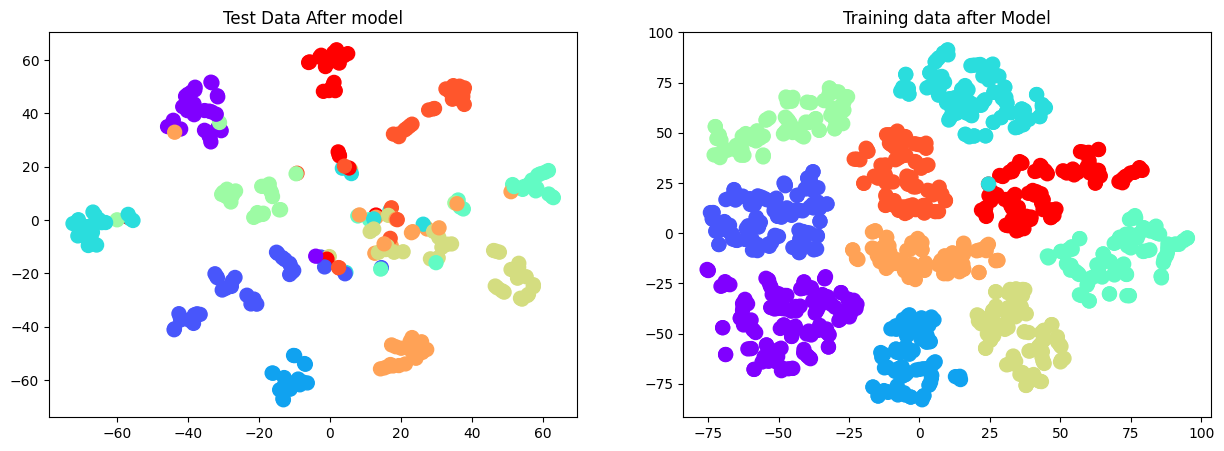

In [ ]:
# prompt: generate a tsne plot for original and after model results for test set with 10 different colours for each label

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original data
ax1.scatter(df_tsne_test['tsne-2d-one'], df_tsne_test['tsne-2d-two'], c=y_test, cmap='rainbow', s=100)
ax1.set_title('Test Data After model')

# Plot the data after model
ax2.scatter(df_tsne_train['tsne-2d-one'], df_tsne_train['tsne-2d-two'], c=np.argmax(y_train, axis=1), cmap='rainbow', s=100)
ax2.set_title('Training data after Model')

# Show the plot
plt.show()


In [ ]:
import os
import glob
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

root_dir = '/content/drive/MyDrive/subject-independent-data'

folders = sorted(glob.glob(os.path.join(root_dir, '*')))

for folder in folders[:32]:
    subfolders = sorted(glob.glob(os.path.join(folder, '*')))
    for subfolder in subfolders:
        X_train = pd.read_csv(os.path.join(subfolder, 'X_train.csv'))
        y_train = pd.read_csv(os.path.join(subfolder, 'y_train.csv'))
        model.fit(X_train, y_train, epochs=13)

for folder in folders[-8:]:
    subfolders = sorted(glob.glob(os.path.join(folder, '*')))
    for subfolder in subfolders:
        X_test = pd.read_csv(os.path.join(subfolder, 'X_test.csv'))
        y_test = pd.read_csv(os.path.join(subfolder, 'y_test.csv'))
        y_pred = model.predict(X_test)

# Calculate evaluation metrics
loss, accuracy = model.evaluate(X_test, y_test, epochs=13)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


49/49 [==============================] - 29s 180ms/step - loss: 2.0894 - accuracy: 0.3496
Epoch 2/13
49/49 [==============================] - 8s 160ms/step - loss: 1.2223 - accuracy: 0.5208
Epoch 3/13
49/49 [==============================] - 8s 161ms/step - loss: 0.7248 - accuracy: 0.7323
Epoch 4/13
49/49 [==============================] - 8s 162ms/step - loss: 0.3253 - accuracy: 0.8545
Epoch 5/13
49/49 [==============================] - 8s 162ms/step - loss: 0.2064 - accuracy: 0.9142
Epoch 6/13
49/49 [==============================] - 8s 163ms/step - loss: 0.2548 - accuracy: 0.9752
Epoch 7/13
49/49 [==============================] - 8s 164ms/step - loss: 0.0689 - accuracy: 0.9807
Epoch 8/13
49/49 [==============================] - 8s 164ms/step - loss: 0.0134 - accuracy: 0.9945
Epoch 9/13
49/49 [==============================] - 8s 165ms/step - loss: 0.0056 - accuracy: 0.9938
Epoch 10/13
49/49 [==============================] - 8s 165ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 11